In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from glob import glob

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Pré-processamento dos dados

In [2]:
entrada = '../input/leishmaniose/'
saida = "./"
batch_size = 10
IMG_SIZE = (224, 224)
base_entrada = glob(entrada)[0] # Pega a string do nome da pasta

In [3]:
train_dataset = image_dataset_from_directory(
    base_entrada,
    validation_split=0.4,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size)

Found 194 files belonging to 2 classes.
Using 136 files for training.


In [4]:
validation_dataset = image_dataset_from_directory(
    base_entrada,
    validation_split=0.4,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size)

Found 194 files belonging to 2 classes.
Using 58 files for validation.


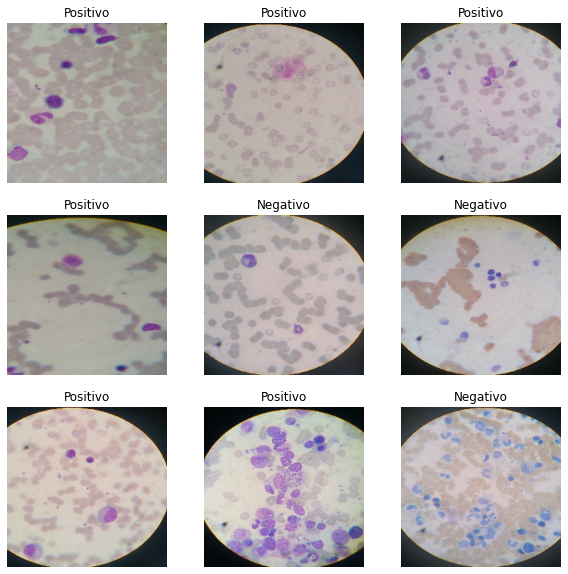

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 224, 224, 3)
(10,)


In [7]:
np.max(image_batch[0])

255.0

In [8]:
# 50% para validação e 50% para teste
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [9]:
print('Número de lotes de validação: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Número de lotes de teste: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 3


In [10]:
# pré-busca em buffer para carregar imagens do disco sem que o I / O se torne um bloqueio
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
# Usando aumento de dados aleatórios somente no fit (treinamento)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    # tf.keras.layers.experimental.preprocessing.RandomRotation(0.1), # retirar por conta dos cantos pretos
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Adição de ruidos (gaussiano), borramento, zoom
# Aumentar a qnt de imagens (~360 pra cada classe)
# classe 1 x3
# classe 0 x5
# 60% treino
# 10% validação
# 30% teste
# Utilizar o kappa na validação da rede neural
# Épocas: 20 + 10
# Métricas [Acurácia, Precision, Recall, F1-score, Kappa, Falso negativo]    


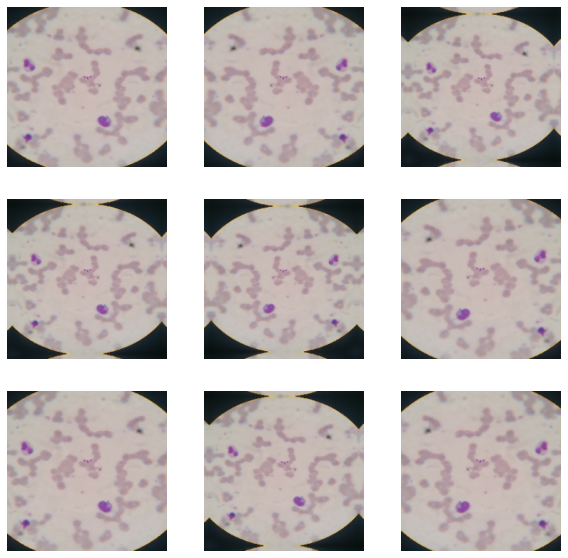

In [12]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [13]:
# Reescala dos valores dos pixels do modelo
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

# Construir um modelo a partir de redes neurais pré-treinadas

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)

# Construir um modelo a partir de redes neurais pré-treinadas
base_model = keras.applications.ResNet152V2(
    weights="imagenet",  # leitura dos pesos pré-treinados da ImageNet.
    input_shape = IMG_SHAPE,
    include_top = False # Não inclui as camadas de classificação no topo, ideal para extração de features
)

234553344/234545216 [==============================] - 2s 0us/step


In [15]:
# converte o IMG_SIZE (224x224x3) de cada imagem em um bloco de features 7x7x2048
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 7, 7, 2048)


# Extração de features

In [16]:
# Freeze the base_model
# Congela a base convolucional antes de compilar e treinar o modelo
# Evita que os pesos em uma determinada camada sejam atualizados durante o treinamento
base_model.trainable = False

In [17]:
# Arquitetura do modelo básico
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [18]:
# Adiciona o cabeçalho de classificação
# Converter as features em um único vetor de 2048 elementos por imagem
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 2048)


In [19]:
# Aplica uma camada densa para converter essas features em uma única previsão por imagem
# Não precisa de uma função de ativação aqui
# Os números positivos preveem a classe 1, os números negativos preveem a classe 0
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


In [20]:
# Modelo encadeando as camadas de aumento de dados, reescalonamento, base_model e extrator de features
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
# Compile o modelo antes de treiná-lo

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [23]:
# Pesos e bias
len(model.trainable_variables)

2

In [24]:
# Avaliação do modelo antes de treinar
loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 6s 147ms/step - loss: 0.7156 - accuracy: 0.4929


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.67
initial accuracy: 0.54


In [26]:
# Treinamento do modelo por 20 épocas
initial_epochs = 20
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
14/14 [==============================] - 12s 196ms/step - loss: 0.7646 - accuracy: 0.5147 - val_loss: 0.7145 - val_accuracy: 0.3571
Epoch 2/20
14/14 [==============================] - 2s 119ms/step - loss: 0.8023 - accuracy: 0.4412 - val_loss: 0.5920 - val_accuracy: 0.4643
Epoch 3/20
14/14 [==============================] - 2s 121ms/step - loss: 0.7032 - accuracy: 0.5074 - val_loss: 0.6160 - val_accuracy: 0.5714
Epoch 4/20
14/14 [==============================] - 3s 120ms/step - loss: 0.7373 - accuracy: 0.5662 - val_loss: 0.6136 - val_accuracy: 0.6071
Epoch 5/20
14/14 [==============================] - 3s 139ms/step - loss: 0.6596 - accuracy: 0.5735 - val_loss: 0.6017 - val_accuracy: 0.5714
Epoch 6/20
14/14 [==============================] - 2s 122ms/step - loss: 0.6329 - accuracy: 0.5662 - val_loss: 0.5967 - val_accuracy: 0.5714
Epoch 7/20
14/14 [==============================] - 2s 122ms/step - loss: 0.6606 - accuracy: 0.6176 - val_loss: 0.6023 - val_accuracy: 0.6429
Epoch

In [27]:
# Curvas de aprendizado da precisão / perda de treinamento e validação ao usar o modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning (Ajuste fino)

In [28]:
# Foi treinado apenas algumas camadas do modelo. 
# Os pesos da rede pré-treinada não foram atualizados durante o treinamento.
# Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores 
# do modelo pré-treinado junto com o treinamento do classificador adicionado (camada de classificação adicionada)
# Descongelar as camadas superiores do modelo (descongelar base_model)
base_model.trainable = True

In [29]:
# LIMIAR PARA AJUSTE FINO (OPCIONAL)
# Definir as camadas inferiores como não treináveis

# Exibe a quantidade de camadas do modelo base
print("Número de camadas no modelo base: ", len(base_model.layers))

# Ajuste fino desta camada em diante
fine_tune_at = 100

# Congele todas as camadas antes da camada 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Número de camadas no modelo base:  564


In [30]:
# É necessário recompilar o modelo (para que essas alterações tenham efeito)

model.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# É importante usar uma taxa de aprendizado mais baixa neste estágio, 
# pois está usando um modelo muito maior e deseja readaptar os pesos pré-treinados

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [32]:
len(model.trainable_variables)

423

In [33]:
# Retomar o treinamento melhorará sua precisão em alguns pontos percentuais

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1], # última época do ultimo treinamento
                         validation_data=validation_dataset)

Epoch 20/30
14/14 [==============================] - 30s 441ms/step - loss: 0.4619 - accuracy: 0.7941 - val_loss: 0.3191 - val_accuracy: 0.8571
Epoch 21/30
14/14 [==============================] - 4s 222ms/step - loss: 0.1955 - accuracy: 0.9750 - val_loss: 0.5262 - val_accuracy: 0.7857
Epoch 22/30
14/14 [==============================] - 4s 237ms/step - loss: 0.1644 - accuracy: 0.9686 - val_loss: 0.1913 - val_accuracy: 0.9643
Epoch 23/30
14/14 [==============================] - 4s 223ms/step - loss: 0.3185 - accuracy: 0.9007 - val_loss: 0.1334 - val_accuracy: 0.9286
Epoch 24/30
14/14 [==============================] - 4s 220ms/step - loss: 0.0986 - accuracy: 0.9583 - val_loss: 0.0915 - val_accuracy: 0.9643
Epoch 25/30
14/14 [==============================] - 4s 223ms/step - loss: 0.0579 - accuracy: 0.9778 - val_loss: 0.3913 - val_accuracy: 0.8929
Epoch 26/30
14/14 [==============================] - 4s 223ms/step - loss: 0.0807 - accuracy: 0.9521 - val_loss: 0.9240 - val_accuracy: 0.750

In [34]:
# Curvas de aprendizado da precisão / perda de treinamento e validação ao ajustar as últimas camadas do modelo
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

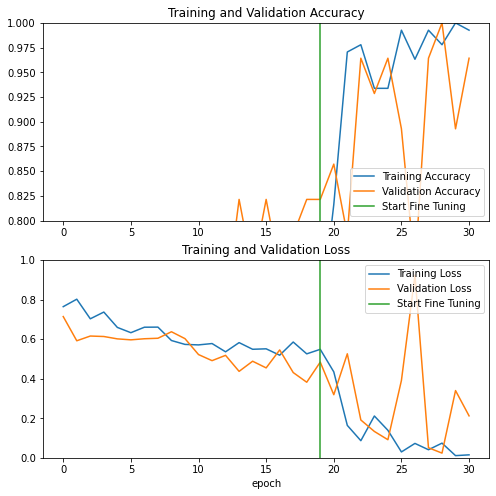

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
# verificar o desempenho do modelo em novos dados usando o conjunto de teste.
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 1s 61ms/step - loss: 0.1482 - accuracy: 0.9667
Test accuracy : 0.9666666388511658


Predictions:
 [0 0 0 0 1 1 0 1 1 1]
Labels:
 [0 0 0 0 1 1 0 1 1 1]


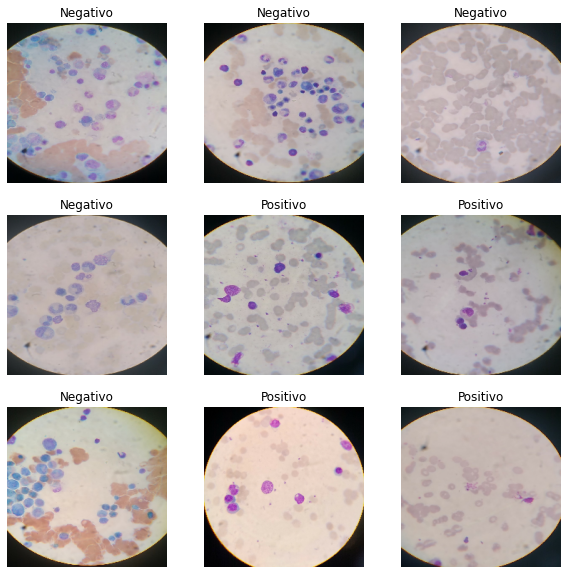

In [37]:
# Recupera um lote de imagens do conjunto de teste
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Aplique um sigmóide uma vez que nosso modelo retorna logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1) # Limiar

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")